In [54]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

learning_rate = 1e-4
keep_prob_rate = 0.7  #
max_epoch = 10
BATCH_SIZE = 32

DOWNLOAD_MNIST = False


def load_dataset(folder_path, ratio=0.7):
    # folder_path 表示数据放的路径
    train_data = []
    test_data = []

    ##随机数种设定，为了每次运行程序，随机数都相同
    random.seed(1)

    ##将类别名统一以数字代替
    label_dict = {label: i for i, label in enumerate(os.listdir(folder_path))}

    ##按radio:1-radio的比例划分出训练集和测试集
    for label in os.listdir(folder_path):
        img_paths = [img_path
                     for img_path in os.listdir(os.path.join(folder_path, label))]

        random.shuffle(img_paths)
        train_data += [(os.path.join(folder_path, label, img), label_dict[label])
                       for img in img_paths[:int(len(img_paths) * ratio)]]
        test_data += [(os.path.join(folder_path, label, img), label_dict[label])
                      for img in img_paths[int(len(img_paths) * ratio):]]

    # transforms.Compose 表示数据预处理
    train_dataset = dataset(
        data=train_data,
        transform=transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )
    test_dataset = dataset(
        data=test_data,
        transform=transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )

    # get_loader获取数据的迭代器
    # shuffle表示是否打乱顺序
    # drop_last表示是否丢掉batch_size不等于BATCH_SIZE的数据
    # num_workers表示计算核数

    # train_dataloader = train_dataset.get_loader(
    #     batch_size=BATCH_SIZE,
    #     shuffle=True,
    #     drop_last=True,
    #     num_workers=4
    # )

    #   使用for循环获取每次batch_size大小的数据
    # for imgs, labels in train_dataloader:
    #     print(imgs.shape, labels.shape)

    return train_dataset, test_dataset


class dataset(Dataset):
    def __init__(self, data, transform=None):
        super(dataset, self).__init__()
        self.data = data
        self.transform = transform

    def get_loader(self, batch_size, shuffle=True, drop_last=False, num_workers=0):
        return DataLoader(self,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          num_workers=num_workers,
                          drop_last=drop_last)

    def __len__(self):
        ##数据总长度
        return len(self.data)

    def __getitem__(self, idx):
        # 每次获取数据中的一条，idx表示数据的下标

        img = Image.open(self.data[idx][0]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = torch.LongTensor([self.data[idx][1]])

        return img, label

In [58]:
import torch
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()   
        self.features = nn.Sequential(                                         #卷积层部分
            nn.Conv2d(3, 48, kernel_size = 11, stride = 4, padding = 2),       #3表示RGB三个通道，48表示Fliter_size         
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(48, 128, kernel_size = 5, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(128, 192, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 192, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(192, 128, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
        )
        
        self.classifier = nn.Sequential(                                   #线性分类器部分
            nn.Dropout(),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace = True),
            nn.Linear(2048, num_classes)          
        )
        
    #def forward(self, x):                                          #向前传播函数
       # x = self.features(x)
       # x = torch.flatten(x, start_dim = 1)
       #x = torch.flatten(x, start_dim = 1)
       # return x
    
    def forward(self, x):                                         #重新定义正向传播的结果
        outputs = []
        for name, moudle in self.features.named_children():       #获取每一层的名字和层结构
            x = moudle(x)
            if name in ["0", "3", "6"]:                                #获取第0层，第3层结果
                outputs.append(x)
        return outputs
    

In [31]:
import os
import json
import time
import torch.optim as optim
import numpy as np

batch_size = 32                                                  #设置批处理大小

root_path = r'G:\\课件\\人工智能\\作业\\实验6_CNN图像\\CNN图像分类'
save_path = root_path  + '\\AlexNet_lab6.pth'
print(root_path)
image_path = root_path + "\\animal\\"

train_dataset, test_dataset = load_dataset(image_path, ratio = 0.7)
train_loader = train_dataset.get_loader(batch_size = batch_size,
                                      shuffle = True,
                                      num_workers = 0,
                                      drop_last = False)

test_loader = test_dataset.get_loader(batch_size = batch_size,
                                      shuffle = True,
                                      num_workers = 0,
                                      drop_last = False)

test_num = len(test_dataset.data)
print(test_num)

net = AlexNet(num_classes = 5)
loss_function = nn.CrossEntropyLoss()                     #多类别的损失交叉熵函数       
optimizer = optim.Adam(net.parameters(), lr = 0.0002)      #Adam优化器，通过lr设置学习率
best_acc= 0.0                                             #用于记录最佳准确率
for epoch in range(100):         #迭代100次
    net.train()
    running_loss = 0.0         #用来统计训练过程的平均损失
    t1 = time.time()
    for step, data in enumerate(train_loader, start = 0):       #遍历数据集
        images, labels = data
        labels = labels.squeeze()                      #降维，去掉batch维
        optimizer.zero_grad()                         #清空之前的梯度信息
        outputs = net(images)                        #得到正向传播信息
        loss = loss_function(outputs, labels)       #计算损失
        loss.backward()                           #将损失反向传播到每个节点
        optimizer.step()                            #更新参数
         
        running_loss += loss.item()                   #损失累加
        rate = (step + 1) / len(train_loader)
         #print("\r", int(rate * 100), "%       ", running_loss, end = "")
    print()
    print("所花费时间为: " + str(time.time() - t1))

    net.eval()
    acc = 0.0
    with torch.no_grad():                                       #验证时不需计算损失梯度
        for test_data in test_loader:                           #遍历测试集
            test_images, test_labels = test_data
            test_labels = test_labels.squeeze()                 #降维
            outputs = net(test_images)                         #得到正向传播的输出值
            predict_y = torch.max(outputs, dim = 1)[1]         #输出的最大值作为预测值
            acc += (predict_y == test_labels).sum().item()     #如果预测结果和标签一样，则acc加1     
        test_accurate = acc / test_num
        if(test_accurate > best_acc):                          #计算当前正确率是否为最佳正确率
            best_acc = test_accurate
            torch.save(net.state_dict(), save_path)              #保存模型
        print('[epoch %d] train_loss: %.3f test_accuracy: %.3f' %(epoch + 1, running_loss / step, test_accurate))
print('Finish Training, best_acc = %.3f' %(best_acc))



G:\\课件\\人工智能\\作业\\实验6_CNN图像\\CNN图像分类
450

所花费时间为: 31.975715160369873
[epoch 1] train_loss: 1.597 test_accuracy: 0.360

所花费时间为: 32.045592308044434
[epoch 2] train_loss: 1.537 test_accuracy: 0.373

所花费时间为: 31.65473175048828
[epoch 3] train_loss: 1.371 test_accuracy: 0.400

所花费时间为: 31.627415657043457
[epoch 4] train_loss: 1.341 test_accuracy: 0.407

所花费时间为: 31.682510137557983
[epoch 5] train_loss: 1.331 test_accuracy: 0.407

所花费时间为: 31.613362789154053
[epoch 6] train_loss: 1.297 test_accuracy: 0.407

所花费时间为: 31.571568489074707
[epoch 7] train_loss: 1.301 test_accuracy: 0.418

所花费时间为: 31.7071316242218
[epoch 8] train_loss: 1.285 test_accuracy: 0.440

所花费时间为: 31.49651551246643
[epoch 9] train_loss: 1.326 test_accuracy: 0.407

所花费时间为: 31.633002042770386
[epoch 10] train_loss: 1.310 test_accuracy: 0.411

所花费时间为: 31.50098466873169
[epoch 11] train_loss: 1.265 test_accuracy: 0.453

所花费时间为: 31.520490407943726
[epoch 12] train_loss: 1.274 test_accuracy: 0.456

所花费时间为: 31.652683973312378
[epoch 13

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1121, 0.2956,  ..., 0.0574, 0.0080, 0.0000],
          ...,
          [0.0000, 0.1074, 0.0000,  ..., 0.0000, 0.0000, 0.0059],
          [0.1325, 0.0000, 0.2084,  ..., 0.0000, 0.0000, 0.0047],
          [0.0900, 0.0646, 0.0066,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0181, 0.0396, 0.0351,  ..., 0.1001, 0.0712, 0.2174],
          [0.0987, 0.1097, 0.1292,  ..., 0.1960, 0.1970, 0.2830],
          [0.1563, 0.1592, 0.2479,  ..., 0.1278, 0.2200, 0.2810],
          ...,
          [0.0191, 0.0000, 0.0454,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0769, 0.0111,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0703,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0067],
          [0.0000, 0.0490, 0.0000,  ..., 

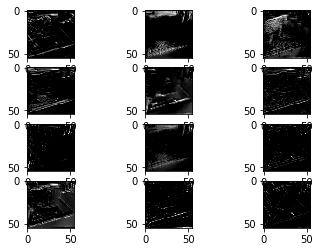

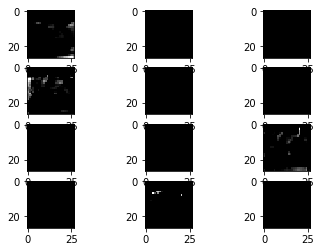

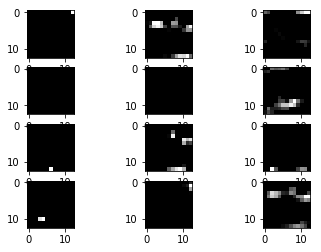

In [59]:
import matplotlib.pyplot as plt

data_transform = transforms.Compose(               #首先定义对数据的预处理
    [transforms.Resize((224, 224)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

path = r'G:\\课件\\人工智能\\作业\\实验6_CNN图像\\CNN图像分类'
model = AlexNet(num_classes = 5)
model.load_state_dict(torch.load(path + '\\AlexNet_lab6.pth'))     #载入模型
#print(model)

img = Image.open(path + '\\predict.jpg')
img = data_transform(img)                   #预处理
img = torch.unsqueeze(img, dim = 0)         #升维

out_put = model(img)
print(out_put)                             #输出已经被改变
for feature_map in out_put:
    im = np.squeeze(feature_map.detach().numpy())      #处理完结果降维
    im = np.transpose(im, [1, 2, 0])            #手动调整参数位置
    
    plt.figure()
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(im[:, :, i], cmap = "gray")
    plt.show()
        